# Metrology Project

In [1]:
import numpy as np
from scipy import stats
from math import sqrt
from scipy.stats import chi2_contingency
import pandas as pd
#Ploting librairies:
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

## Recap 1. 2. 3. Group part

1.Energy balance of the system:  
$Q1= ṁ_CC_{pC}(TB-TA)$  
$Q1= ṁ_MC_{pM}(TG-TH)$  
  
$Q2 =  ṁ_MC_{pM}(TD-TC)$  
$Q2=  ṁ_MC_{pM}(TF-TG)$  
  
$Q3 =  ṁ_MC_{pM}(TE-TD)$  
$Q3= ṁ_HC_{pH}(TI-TJ)$


3.We are searching for: Q1, Q2, Q3.  
Those are not solvable with 1 or 2 sensors.  
We need at least 3 sensors (35 + 35 = 70 possibilities to check).  
Differents possible combinations with 3 sensors:   
1. Tb, Td, Te (direct)	Mona  
2. Tb, Te, Tg (find Td)	Hortense  
3. Tb, Te, Th (find Tg, Td)  
__4.Td, Te, Th (find Tg)	Jolan__  
__5.Te, Tg, Th (find Td)	Jolan__  

Different possible combinations with 4 sensors (excluding the ones possible with three):  
6. mh, Tb, Td, Tj (direct)	Hortense  
7. mh, Tb, Te, Tj (find Td)   Mona  
8. mh, Tb, Tg, Tj (direct)	Julien  
9. mh, Tb, Th, Tj (find Tg)	Julien  
10. mh, Td, Th, Tj (find Tg)  
11. mh, Te, Th, Tj (find Td,Tg)  
12. mh, Tg, Th, Tj (direct)


## 4. Find their price and precision while comparing Monte Carlo and numerical derivative methods

In this part, I will deal with the combination __(Td, Te, Th)__ and __(Te, Tg, Th)__.  

The value and the standard deviation of __Q1__, __Q2__, __Q3__ will be given with the numerical derivative method and the Monte Carlo one.   
In order to access Q1, Q3 one has to access first __Tg__ for the first combination ( Td,Te,Th) and __Td__ for the second (Te,Tg,Th).

In [2]:
#Init
mM = 1 #kg/s
CpM = 3800 #J/(kg.K)
Tc = 5.5
Tf = 65

Th = 7
deltaTh = 0.3
Thprice = 400

Te = 68.3
deltaTe = 0.3
Teprice = 500

Td = 60.5
deltaTd = 0.5
Tdprice = 300

Tg = 10
deltaTg = 0.3
Tgprice = 450

### __Numerical derivative method__

In [3]:
#Functions

def Q_(m,Cp,Tout,Tin):
    return m*Cp*(Tout-Tin)

def T_(Q2,m,Cp,Tin):
    #-Q2 for Tg
    return Tin + Q2/(m*Cp)

def std_Q(m,C,Tout,Tin,deltaTout,deltaTin):
    dQdTout = (Q_(m,C,Tout+(deltaTout/1000),Tin)-Q_(m,C,Tout,Tin))/(deltaTout/1000)
    dQdTin = (Q_(m,C,Tout,Tin+(deltaTin/1000))-Q_(m,C,Tout,Tin))/(deltaTin/1000)
    Q = Q_(m,C,Tout,Tin)
    return np.sqrt(dQdTout**2*(deltaTout/Q)**2
                    +dQdTin**2*(deltaTin/Q)**2)

def std_Q2(m,C,Tout,Tin,deltaTout):
    dQdTout = (Q_(m,C,Tout+(deltaTout/1000),Tin)-Q_(m,C,Tout,Tin))/(deltaTout/1000)
    Q = Q_(m,C,Tout,Tin)
    return dQdTout*(deltaTout/Q)

def std_T(m,C,T2,Q2,deltaQ2):
    #-Q2 for Tg
    dTdQ2 = (T_(Q2+(deltaQ2/1000),m,C,T2)-T_(Q2,m,C,T2))/(deltaQ2/1000)
    T = T_(Q2,m,C,T2)
    return dTdQ2*(deltaQ2/T)

##### __(Td, Te, Th)__

In [4]:
#Q3 calculation
Q3 = Q_(mM,CpM,Te,Td)
stdQ3 = std_Q(mM,CpM,Te,Td,deltaTe,deltaTd)

#Q2 Calculation
Q2 = Q_(mM,CpM,Td,Tc)
stdQ2 = std_Q2(mM,CpM,Td,Tc,deltaTd)

#Tg calculation
Tg_calc = T_(-Q2,mM,CpM,Tf)
stdTg = std_T(mM,CpM,Tf,-Q2,stdQ2*Q2) #stdQ2*Q2 is the absolute deviation

#Q1 calculation
Q1 = Q_(mM,CpM,Tg_calc,Th)
stdQ1 = std_Q(mM,CpM,Tg_calc,Th,stdTg*Tg,deltaTh) #Same here for stdTg*Tg

#Total Error
ErrorComb = (1/3)*(np.sqrt(stdQ1**2+stdQ2**2+stdQ3**2)) #1/nb of std

In [5]:
print(f"Q1 = {Q1}J +/- {stdQ1*100}%")
print("et")
print(f"Q2 = {Q2} +/- {stdQ2*100}%")
print("et")
print(f"Q3 = {Q3} +/- {stdQ3*100}%")
print(f"The total error with the derivative method is {ErrorComb*100}%")

Q1 = 11400.0J +/- 19.43650631642749%
et
Q2 = 209000.0 +/- 0.9090909091020493%
et
Q3 = 29639.99999999999 +/- 7.475579352364763%
The total error with the derivative method is 6.948129330362877%


##### __(Te, Tg, Th)__

In [6]:
#Q1 calculation
Q1b = Q_(mM,CpM,Tg,Th)
stdQ1b = std_Q(mM,CpM,Tg,Th,deltaTg,deltaTh)

#Q2 calculation
Q2b = Q_(mM,CpM,Tf,Tg)
stdQ2b = std_Q2(mM,CpM,Tf,Tg,deltaTg)

#Td calculation
Td_calc = T_(Q2,mM,CpM,Tc)
stdTd = std_T(mM,CpM,Tc,Q2b,stdQ2b*Q2b)

#Q3 calculation
Q3b = Q_(mM,CpM,Te,Td_calc)
stdQ3b = std_Q(mM,CpM,Te,Td_calc,deltaTe,stdTd*Td_calc)

#Total Error
ErrorCombb = (1/3)*(np.sqrt(stdQ1b**2+stdQ2b**2+stdQ3b**2)) 

In [7]:
print(f"Q1 = {Q1b} J +/- {stdQ1b*100}%")
print("et")
print(f"Q2 = {Q2b} J +/- {stdQ2b*100}%")
print("et")
print(f"Q3 = {Q3b} J +/- {stdQ3b*100}%")
print(f"The total error with the derivative method is {ErrorCombb*100}%")

Q1 = 11400 J +/- 14.142135623723732%
et
Q2 = 209000 J +/- 0.5454545454473043%
et
Q3 = 29639.99999999999 J +/- 5.439282932132004%
The total error with the derivative method is 5.053967852387836%


### __Monte Carlo method__

In [37]:
#Monte-Carlos function
def std_QCarlos(m,C,Tout,Tin,deltaTout,deltaTin,M,epsilon):
    Q, STD, Mean = [] , [] , []
    Toutlist,Tinlist = [], []
    for t in range(M):
        Toutlist.append(np.random.normal(Tout,deltaTout))
        Tinlist.append(np.random.normal(Tin,deltaTin))
        Q.append(Q_(m,C,Toutlist[-1],Tinlist[-1]))
        if len(Q)>10: #Force to do at least 10 iterations
            STD.append(np.std(Q))
            Mean.append(np.mean(Q))
        if len(STD)>2 and abs(STD[-1] - STD[-2])/STD[-2]<epsilon and abs(Mean[-1] - Mean[-2])/Mean[-2]<epsilon:
            return Mean, STD
        
def std_Q2Carlos(m,C,Tout,Tin,deltaTout,M,epsilon = 1e-5):
    #Need a higher precision epsilon to converge
    Q, STD, Mean = [] , [] , []
    Toutlist = []
    for t in range(M):
        Toutlist.append(np.random.normal(Tout,deltaTout))
        Q.append(Q_(m,C,Toutlist[-1],Tin))
        if len(Q)>10:
            STD.append(np.std(Q))
            Mean.append(np.mean(Q))
        if len(STD)>2 and abs(STD[-1] - STD[-2])/STD[-2]<epsilon and abs(Mean[-1] - Mean[-2])/Mean[-2]<epsilon:
            return Mean, STD      

def std_TCarlos(m,C,T2,Q2,deltaQ2,M, epsilon = 1e-5):
    # -Q2 for Tg
    #Need a higher precision epsilon to converge propely
    T, STD, Mean = [] , [] , []
    Q2list = []
    for t in range(M):
        Q2list.append(np.random.normal(Q2,deltaQ2))
        T.append(T_(Q2list[-1],m,C,T2))
        if len(T)>10:
            STD.append(np.std(T))
            Mean.append(np.mean(T))
        if len(STD)>2 and abs(STD[-1] - STD[-2])/STD[-2]<epsilon and abs(Mean[-1] - Mean[-2])/Mean[-2]<epsilon:
            return Mean, STD
        
def PlotConv(STD,Mean,name):
    fig, axs = plt.subplots(2,1)
    T = np.linspace(10,len(STD),len(STD))
    axs[0].plot(T,STD,'r',label = 'Standard deviation of '+name)
    axs[0].legend()
    axs[1].plot(T,Mean,'b', label = 'Mean of ' + name)
    axs[1].set_xlabel('Nb of iterations')
    axs[1].legend()

##### __(Td, Te, Th)__

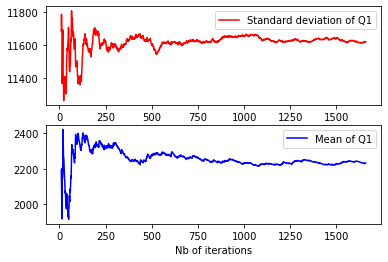

In [56]:
#MonteCarlos paramaters
M = int(1e4)
epsilon = 1e-4

#Q3 calculation
MeanQ3Carlos, STDQ3Carlos = std_QCarlos(mM,CpM,Te,Td,deltaTe,deltaTd,M,epsilon)
#PlotConv(MeanQ3Carlos,STDQ3Carlos,"Q3")
Q3Carlos , stdQ3Carlos = MeanQ3Carlos[-1], STDQ3Carlos[-1]
# % std: stdQ3Carlos/Q3Carlos*100

#Q2 Calculation
MeanQ2Carlos, STDQ2Carlos = std_Q2Carlos(mM,CpM,Td,Tc,deltaTd,M)
#PlotConv(MeanQ2Carlos,STDQ2Carlos,"Q2")
Q2Carlos , stdQ2Carlos = MeanQ2Carlos[-1], STDQ2Carlos[-1]
# % std: stdQ2Carlos/Q2Carlos*100

#Tg calculation
MeanTgCarlos, STDTgCarlos = std_TCarlos(mM,CpM,Tf,-Q2Carlos,stdQ2Carlos,M)
#PlotConv(MeanTgCarlos,STDTgCarlos,"Tg")
TgCarlos , stdTgCarlos = MeanTgCarlos[-1], STDTgCarlos[-1]
# % std: stdTgCarlos/TgCarlos*100

#Q1 calculation
MeanQ1Carlos, STDQ1Carlos = std_QCarlos(mM,CpM,TgCarlos,Th,stdTgCarlos,deltaTh,M,epsilon)
PlotConv(MeanQ1Carlos,STDQ1Carlos,"Q1")
Q1Carlos , stdQ1Carlos = MeanQ1Carlos[-1], STDQ1Carlos[-1]
# % std: stdQ1Carlos/Q1Carlos*100

#Total Error
ErrorCombCarlos = (1/3)*(np.sqrt((stdQ1Carlos/Q1Carlos)**2
                           +(stdQ2Carlos/Q2Carlos)**2
                           +(stdQ3Carlos/Q3Carlos)**2))

In [57]:
print(f"Q1 = {Q1Carlos} J +/- {stdQ1Carlos/Q1Carlos*100}%")
print("et")
print(f"Q2 = {Q2Carlos} J +/- {stdQ2Carlos/Q2Carlos*100}%")
print("et")
print(f"Q3 = {Q3Carlos} J+/- {stdQ3Carlos/Q3Carlos*100}%")
print(f"The total error with the Monte Carlos is {ErrorCombCarlos*100}%")

Q1 = 11621.097550555543 J +/- 19.198787932703897%
et
Q2 = 208978.13865085825 J +/- 0.9326171129923797%
et
Q3 = 29607.053669113564 J+/- 7.543441297108597%
The total error with the Monte Carlos is 6.882883273158345%


##### __(Te, Tg, Th)__

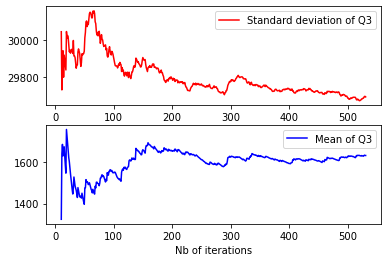

In [40]:
#MonteCarlos paramaters
M = int(1e4)
epsilon = 1e-4

#Q1 calculation
MeanQ1bCarlos, STDQ1bCarlos = std_QCarlos(mM,CpM,Tg,Th,deltaTg,deltaTh,M,epsilon)
#PlotConv(MeanQ1bCarlos,STDQ1bCarlos,"Q1")
Q1bCarlos , stdQ1bCarlos = MeanQ1bCarlos[-1], STDQ1bCarlos[-1]
# % std: stdQ1bCarlos/Q1bCarlos*100

#Q2 Calculation
MeanQ2bCarlos, STDQ2bCarlos = std_Q2Carlos(mM,CpM,Tf,Tg,deltaTg,M)
#PlotConv(MeanQ2bCarlos,STDQ2bCarlos,"Q2")
Q2bCarlos , stdQ2bCarlos = MeanQ2bCarlos[-1], STDQ2bCarlos[-1]
# % std: stdQ2bCarlos/Q2bCarlos*100

#Td calculation
MeanTdCarlos, STDTdCarlos = std_TCarlos(mM,CpM,Tc,Q2bCarlos,stdQ2bCarlos,M)
#PlotConv(MeanTdCarlos,STDTdCarlos,"Td")
TdCarlos , stdTdCarlos = MeanTdCarlos[-1], STDTdCarlos[-1]
# % std: stdTdCarlos/TdCarlos*100

#Q3calculation
MeanQ3bCarlos, STDQ3bCarlos = std_QCarlos(mM,CpM,Te,TdCarlos,deltaTe,stdTdCarlos,M,epsilon)
PlotConv(MeanQ3bCarlos,STDQ3bCarlos,"Q3")
Q3bCarlos , stdQ3bCarlos = MeanQ3bCarlos[-1], STDQ3bCarlos[-1]
# % std: stdQ3bCarlos/Q3bCarlos*100

#Total Error
ErrorCombCarlosb = (1/3)*(np.sqrt((stdQ1bCarlos/Q1bCarlos)**2
                           +(stdQ2bCarlos/Q2bCarlos)**2
                           +(stdQ3bCarlos/Q3bCarlos)**2)) 

In [42]:
print(f"Q1 = {Q1bCarlos} J +/- {stdQ1bCarlos/Q1bCarlos*100}%")
print("et")
print(f"Q2 = {Q2bCarlos} J +/- {stdQ2bCarlos/Q2bCarlos*100}%")
print("et")
print(f"Q3 = {Q3bCarlos} J+/- {stdQ3bCarlos/Q3bCarlos*100}%")
print(f"The total error with the Monte Carlos is {ErrorCombCarlosb*100}%")

Q1 = 11428.341154584079 J +/- 14.049590256210184%
et
Q2 = 208977.55735124546 J +/- 0.5364695066725714%
et
Q3 = 29695.313155252825 J+/- 5.493263441935309%
The total error with the Monte Carlos is 5.031619235080499%


#### Bilan

In [58]:
Bilan = pd.DataFrame(index = ["Q1", "Q2","Q3","Total error"])
Bilan["Derivative method for (Td, Te, Th) [%]"] = [stdQ1*100,stdQ2*100,stdQ3*100,ErrorComb*100]
Bilan["Monte Carlos method for (Td, Te, Th) [%]"] = [stdQ1Carlos/Q1Carlos*100,stdQ2Carlos/Q2Carlos*100,
                                                     stdQ3Carlos/Q3Carlos*100,ErrorCombCarlos*100]
Bilan["Derivative method for (Te,Tg,Th) [%]"] = [stdQ1b*100,stdQ2b*100,stdQ3b*100,ErrorCombb*100]
Bilan["Monte Carlos method for (Te,Tg,Th) [%]"] = [stdQ1bCarlos/Q1bCarlos*100,stdQ2bCarlos/Q2bCarlos*100,
                                                   stdQ3bCarlos/Q3bCarlos*100,ErrorCombCarlosb*100]
Bilan

Derivative method for (Td, Te, Th) [%]  \
Q1                                        19.436506   
Q2                                         0.909091   
Q3                                         7.475579   
Total error                                6.948129   

             Monte Carlos method for (Td, Te, Th) [%]  \
Q1                                          19.198788   
Q2                                           0.932617   
Q3                                           7.543441   
Total error                                  6.882883   

             Derivative method for (Te,Tg,Th) [%]  \
Q1                                      14.142136   
Q2                                       0.545455   
Q3                                       5.439283   
Total error                              5.053968   

             Monte Carlos method for (Te,Tg,Th) [%]  
Q1                                        14.049590  
Q2                                         0.536470  
Q3                                         5.493263  
Total error                                5.031619

The standard deviation for each method are similar conforting us in the validiy of the error results.    
We were able to see that the Monte Carlos method is more variable when different standard deviation are calculated which is normal because the heat is calculated with a temperature that can vary itself. 
One has to be careful and looking at all convergence curves to be sure to obtain a good convergence for each measure.  
Now, to not influence a method over an other we will take the mean value of the two total error obtained for each method.

In [59]:
Error1 = np.mean([ErrorComb,ErrorCombCarlos])
Error2 = np.mean([ErrorCombb,ErrorCombCarlosb])

### Price calculation

##### __(Td, Te, Th)__

In [60]:
price = Tdprice+Teprice+Thprice
print(f"The price of this combination is {price} €")

The price of this combination is 1200 €


##### __(Te, Tg, Th)__

In [61]:
priceb = Tgprice+Teprice+Thprice
print(f"The price of this combination is {priceb} €")

The price of this combination is 1350 €


## 5. Draw Pareto Curve and Suggest the best solution

My results:

In [64]:
Pareto = pd.DataFrame(index = ["(Td, Te, Th)", "(Te,Tg,Th)"])
Pareto["Incertitude [%]"] = [Error1*100, ErrorCombb*100]
Pareto["Price [€]"] = [price, priceb]
#sns.lmplot(x = 'Prix [€]', y = 'Incertitude [%]', data = Pareto, fit_reg=False)
Pareto

Incertitude [%]  Price [€]
(Td, Te, Th)         6.915506       1200
(Te,Tg,Th)           5.053968       1350

Added to the results of everyone:

(800.0, 2800.0)

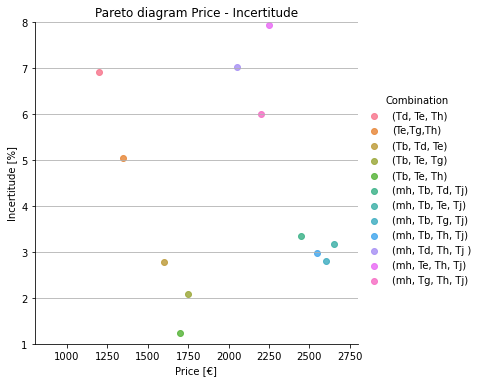

In [65]:
#Data of the others
Pareto.loc[2] = [2.77173,1600] # 1. Tb, Td, Te
Pareto.loc[3] = [2.074356,1750] # 2. Tb, Te, Tg
Pareto.loc[4] = [1.238,1700] # 3. Tb, Te, Th
Pareto.loc[5] = [3.358661,2450] # 6.  mh, Tb, Td, Tj
Pareto.loc[6] = [3.1666,2650] # 7.  mh, Tb, Te, Tj
Pareto.loc[7] = [2.7957386,2600] # 8. mh, Tb, Tg, Tj
Pareto.loc[8] = [2.98562,2550] # 9. mh, Tb, Th, Tj
Pareto.loc[9] = [7.02101,2050] # 10. mh, Td, Th, Tj
Pareto.loc[10] = [7.93505,2250] # 11. mh, Te, Th, Tj
Pareto.loc[11] = [6.00544,2200] # 12. mh, Tg, Th, Tj 

# change index name
Pareto.rename(index = {2: '(Tb, Td, Te)', 
                        3: '(Tb, Te, Tg)', 
                        4:'(Tb, Te, Th)', 
                        5:'(mh, Tb, Td, Tj)',
                        6:'(mh, Tb, Te, Tj)', 
                        7:'(mh, Tb, Tg, Tj)', 
                        8:'(mh, Tb, Th, Tj)',
                        9:'(mh, Td, Th, Tj )',
                        10:'(mh, Te, Th, Tj)',
                        11:'(mh, Tg, Th, Tj)'}, inplace = True)

#Plot
Pareto['Combination'] = Pareto.index
sns.lmplot(x = 'Price [€]', y = 'Incertitude [%]', data = Pareto, fit_reg=False,hue= 'Combination', legend = True)
plt.title("Pareto diagram Price - Incertitude")
plt.grid(axis ='y')
plt.ylim([1,8])
plt.xlim([800,2800])

According to this Pareto diagram the best solution seems to be __(Tb,Te,Th)__ at 1700€.  
Another solution a bit less expensive could be the __(Tb,Td,Te)__ at 1600€.  